# Importing Snapshots from OpenFOAM

**Aim of this notebook:** learn how to import parametric snapshots from OpenFOAM (version 6 from org-version) using *fluidfoam* package.

The snapshots are related to the Buoyant Cavity problem in fluid dynamics, governed by the Navier-Stokes equations, including energy, under the Boussinesq approximation. In particular, the snapshots have been generated using the case reported in [ROSE-ROM4FOAM tutorials](https://ermete-lab.github.io/ROSE-ROM4FOAM/Tutorials/BuoyantCavity/problem.html).

*Disclaimer*: the OpenFOAM snapshots are not included in the Zenodo repository for storage issues, but they can be generated using the case reported in the link above. Therefore, to generate the OpenFOAM case and later execute this notebook, you need to have OpenFOAM-v6 installed in your machine.
For interested readers, please contact stefano.riva@polimi.it.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from mpi4py import MPI
from dolfinx.io import gmshio
import gmsh
from dolfinx.fem import Function, FunctionSpace
import ufl

from pyforce.tools.functions_list import FunctionsList
from pyforce.tools.backends import LoopProgress

path = './Snapshots/OpenFOAM/'

importing = ['TrainSet', 'TestSet']

var_names = ['p', 'T', 'U']
is_vector = [False, False, True]

The snapshots are dependent on two different parameters: the Reynolds and the Richardson number, split into train and test set
\begin{equation*}
\begin{array}{cc}
Re_{train} = [15:5:150] & Ri_{train} = [0.2:0.4:5] \\
Re_{test} = [17.5:10:147.5] & Ri_{test} = [0.4:0.8:44] 
\end{array}
\end{equation*}

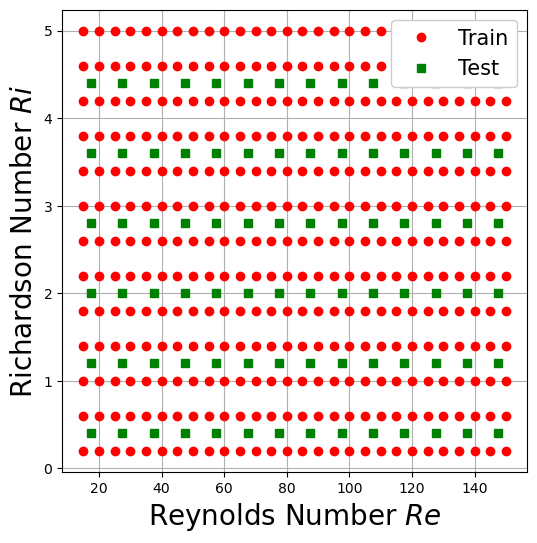

In [2]:
dRe = 5.
dRi = 0.4

# Train/Test Parameters
Re_train_test = [np.arange(15,  150+dRe/2, dRe), np.arange(15+dRe/2,  150+dRe/2, dRe*2)]
Ri_train_test = [np.arange(0.2,   5+dRi/2, dRi), np.arange(0.2+dRi/2,   5+dRi/2, dRi*2)  ]

mu_train_test = [np.meshgrid(Re_train_test[kk], Ri_train_test[kk]) for kk in range(len(importing))]

fig = plt.figure(figsize=(6,6))

plt.plot(mu_train_test[0][0].flatten(), mu_train_test[0][1].flatten(), 'ro', label='Train')
plt.plot(mu_train_test[1][0].flatten(), mu_train_test[1][1].flatten(), 'gs', label='Test')
plt.xlabel('Reynolds Number $Re$', fontsize=20)
plt.ylabel('Richardson Number $Ri$', fontsize=20)
plt.grid()
plt.legend(framealpha=1, fontsize=15, loc='upper right')

Let us generate the mesh for importing OpenFOAM dataset into *dolfinx*

In [3]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cavity.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Import into dolfinx
model_rank = 0
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )
gmsh.finalize()

########################################################################################################

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

Info    : Reading 'cavity.geo'...
Info    : Done reading 'cavity.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000510708s, CPU 0.000353s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00321s, CPU 0.001525s)
Info    : 16384 nodes 32770 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 1.458e-06s, CPU 1e-06s)


Let us define the functional space onto which the OpenFOAM data are projected.

In [4]:
fun_spaces = [FunctionSpace(domain, ('Lagrange', 1)), FunctionSpace(domain, ('Lagrange', 1)), FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1))]

Let us import the pressure $p$, temperature $T$ and velocity $\mathbf{u}$ fields. The mapping between OpenFOAM and *dolfinx* is performed using $N$-dimensional interpolation implemented in *scipy*.

`pyforce` comes with a class called `ReadFromOF`: this class requires the path to the OpenFOAM case, there is also an option to specify if the centroids of the cells must be imported. The class uses two important methods:

- `import_field`: imports the field from OpenFOAM into numpy arrays
- `foam_to_dolfinx`: interpolates the OpenFOAM field into the dolfinx mesh using *scipy*

In [ ]:
from pyforce.tools.write_read import ReadFromOF, StoreFunctionsList as store

impo_i = 0 # for TrainSet
impo_i = 1 # for TestSet

dolfinx_path = './Snapshots/'+importing[impo_i]+'_'
snaps = {var_names[field_i]: FunctionsList(fun_spaces[field_i]) for field_i in range(len(var_names))}

for field_i in range(len(var_names)):
    bar = LoopProgress('Import '+var_names[field_i]+' - '+importing[impo_i], final = len(Re_train_test[impo_i]) * len(Ri_train_test[impo_i]))

    caseI = 0
    for Re_i in range(len(Re_train_test[impo_i])):
        Re = Re_train_test[impo_i][Re_i]
        for Ri_i in range(len(Ri_train_test[impo_i])):
            Ri = Ri_train_test[impo_i][Ri_i]

            path_ = path+importing[impo_i]+'/'+f'Case_{caseI+0:03}_Re{Re:.2f}_Ri{Ri:.2f}'

            oF = ReadFromOF(path=path_, extract_dofs=True, mode='fluidfoam')
            of_snaps = oF.import_field(var_names[field_i], vector=is_vector[field_i], verbose=False)[0]

            # Projection in dolfinx
            dolfinx_snap = oF.foam_to_dolfinx(fun_spaces[field_i], of_snaps, variables=['x', 'y'],  cut_value = oF.of_dofs[2,0])

            for uu in dolfinx_snap._list:
                snaps[var_names[field_i]].append(uu)
            
            bar.update(1)
            caseI += 1
    del bar
    
    store(domain, snaps[var_names[field_i]], var_names[field_i], dolfinx_path+var_names[field_i])

Let us normalise the temperature field, using `min-max` to have it scaled between $(0,1)$.

In [27]:
from pyforce.tools.write_read import ImportH5

field_i = 1
field = var_names[field_i]

for imp in importing:
    dolfinx_path = './Snapshots/'+imp+'_'

    T_snaps = ImportH5(fun_spaces[field_i], dolfinx_path+field, field)[0]

    if imp == 'TrainSet':
        _min = min([np.min(snap) for snap in T_snaps._list])
        _max = max([np.max(snap) for snap in T_snaps._list])

    T_norm_snaps = FunctionsList(T_snaps.fun_space)
    for snap in T_snaps._list:
        T_norm_snaps.append((snap - _min) / (_max - _min))
        
    store(domain, T_norm_snaps, 'norm_'+field, dolfinx_path+'norm_'+field)